In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [2]:
def isNaN(value):
    return value != value

In [3]:
# read in data
pd_loan = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)
pd_loan.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0


In [ ]:
# cleaning Data
# first viewing categories of data which are object
categories = pd_loan.select_dtypes(include=['object'])
for x in categories:
    column = categories[x]
    print(x)
    print(column.nunique())

In [ ]:
# check the columns with NaN values
nrow = pd_loan.shape[0]
for ptr_row in range(nrow):
    for ptr_col in pd_loan.columns:
        if isNaN(pd_loan.loc[ptr_row, ptr_col]):
            print('row {} & col {}'.format(ptr_row, ptr_col))

In [4]:
# for 'object' of many types, converting them to numeric
pd_loan_cln = pd_loan.copy(deep=True)
pd_loan_cln['id'] = pd.to_numeric(pd_loan_cln['id'], errors='coerce')
pd_loan_cln['int_rate'] = pd.to_numeric(pd_loan_cln['int_rate'].str.strip('%'), errors='coerce')
pd_loan_cln['purpose'] = pd_loan_cln['purpose'].str
pd_loan_cln['title'] = pd_loan_cln['title'].str

In [5]:
# drop columns with many types & unimportant in model building
pd_loan_cln.drop(['emp_title', 'url', 'desc', 'zip_code', 'earliest_cr_line', 
                       'revol_util', 'sub_grade', 'addr_state'], 1, inplace=True)
# drop additional columns 
pd_loan_cln.drop(['member_id', 'funded_amnt_inv', 'issue_d', 'purpose', 'title', 'initial_list_status', 'last_pymnt_d', 
              'next_pymnt_d', 'last_credit_pull_d'], 1, inplace=True)
#pd_loan_cln.drop(['verification_status_joint_Not Verified', 'verification_status_joint_Source Verified', 
#             'verification_status_joint_Verified', 'verification_status_Verified'], 1, inplace=True)
pd_loan_cln.drop(['tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
             'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75'], 1, inplace=True)
pd_loan_cln.drop(['collections_12_mths_ex_med', 'mths_since_last_major_derog', 'open_acc_6m', 'open_il_6m', 
                  'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 
                  'open_rv_24m', 'max_bal_bc', 'inq_last_12m', 'acc_open_past_24mths', 'mo_sin_old_il_acct',
                   'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'inq_last_6mths', 
                  'mths_since_last_delinq', 'mths_since_last_record'], 1, inplace=True)
pd_loan_cln.drop(['mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
        'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'all_util', 'total_rev_hi_lim', 'inq_fi', 
        'total_cu_tl', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'collection_recovery_fee',
        'verification_status_joint', 'annual_inc_joint', 'dti_joint', 'emp_length'], 1, inplace=True)

In [6]:
# removing last two rows
pd_loan_cln = pd_loan_cln[:-2]

In [7]:
pd_loan_cln.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'pymnt_plan', 'dti', 'delinq_2yrs', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype='object')

In [8]:
# cleaning data,  removing loan_status== 'Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'
pd_loan_pad = pd_loan_cln[pd_loan_cln.loan_status != 'Charged Off']
pd_loan_pad = pd_loan_pad[pd_loan_pad.loan_status != 'Fully Paid']
pd_loan_pad = pd_loan_pad[pd_loan_pad.loan_status != 'In Grace Period']
pd_loan_pad = pd_loan_pad[pd_loan_pad.loan_status != 'Late (16-30 days)']
pd_loan_pad = pd_loan_pad[pd_loan_pad.loan_status != 'Late (31-120 days)']

In [22]:
print(pd_loan_pad.groupby(['loan_status']).count())

                 id  loan_amnt  funded_amnt    term  int_rate  installment  \
loan_status                                                                  
Current      287414     287414       287414  287414    287414       287414   
Default         796        796          796     796       796          796   

              grade  home_ownership  annual_inc  verification_status  \
loan_status                                                            
Current      287414          287414      287414               287414   
Default         796             796         796                  796   

               ...      policy_code  application_type  acc_now_delinq  \
loan_status    ...                                                      
Current        ...           287414            287414          287414   
Default        ...              796               796             796   

             tot_coll_amt  tot_cur_bal  chargeoff_within_12_mths  delinq_amnt  \
loan_status             

In [9]:
# with DataFrame pd_loan_pad, we will build a decision tree
from sklearn import tree
from IPython.display import Image
import pydotplus
#import graphviz

X = pd_loan_pad.drop(['loan_status'], 1)
Y = pd_loan_pad['loan_status']
X = pd.get_dummies(X)

my_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=5,
    random_state=1337)
my_tree.fit(X, Y)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1337, splitter='best')

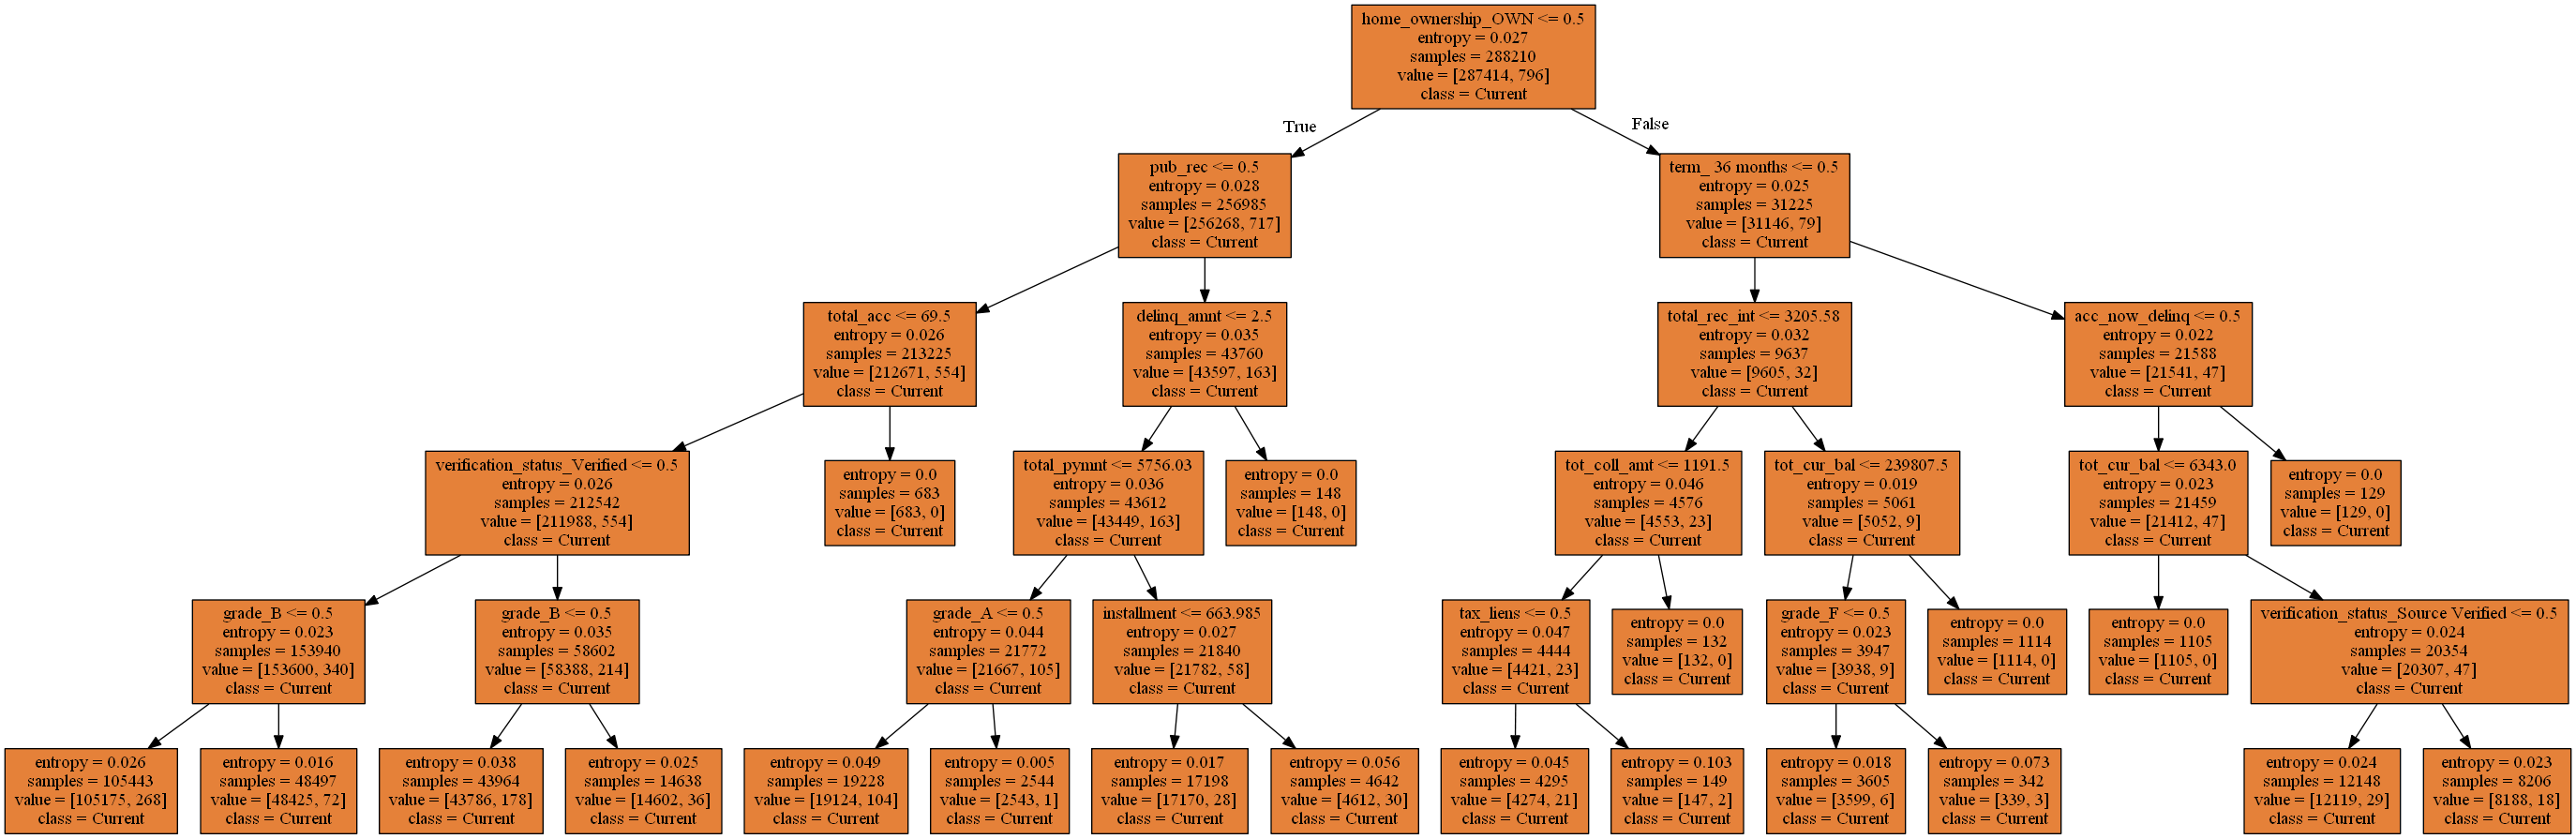

In [10]:
dot_data = tree.export_graphviz(my_tree, out_file=None, feature_names=X.columns, 
                               class_names=['Current', 'Default'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [12]:
# Now build RandomForest 
randomforest_c = ensemble.RandomForestClassifier()
cross_val_score(randomforest_c, X, Y, cv=5)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: F

array([0.44282914, 0.99753652, 0.99722425, 0.99724159, 0.99724155])